In [6]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import methods.util as util
import methods.shared as shared
import pandas as pd
import pickle
import scipy.stats 


In [16]:
#load growth curve and barcode seq data

gc_data = pd.read_excel(f'../data/other/tableS5_invitro_growth_curves.xlsx',
                        sheet_name = ['well_identities', 
                                    'plate1_week1_passage1', 'plate2_week1_passage1', 
                                    'plate1_week3_passage8', 'plate2_week3_passage8',
                                    'plate1_week5_passage15', 'plate2_week5_passage15',
                                    'plate1_week9_passage29', 'plate2_week9_passage29'])

# in vitro
with open(f'../data/pickled/vitro_read_array.pkl', 'rb') as f:
    read_array = pickle.load(f)
vitro_freqs = np.einsum('ij, i->ij', read_array, read_array.sum(axis=1)**-1.)

with open(f'../data/pickled/vitro_array_meta.pkl', 'rb') as f:
    vitro_array_meta = pickle.load(f)
barcodes = vitro_array_meta['barcodes']
vitro_meta = vitro_array_meta['well_meta']
vitro_row_ids = vitro_array_meta['well_row_ids']
medium_to_well_map = vitro_array_meta['medium_well_map']
well_to_medium_map = vitro_array_meta['well_medium_map']

high_freq_at_least_once = np.max(vitro_freqs, axis=0) > 0.01

KeyboardInterrupt: 

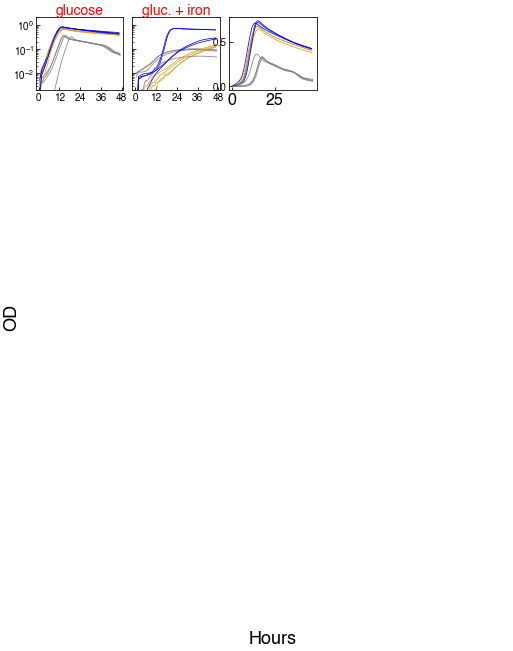

In [ ]:
# since switcing to pandas, this figure takes several minutes to run...

fig = plt.figure( figsize=(8.5, 11) )
gs = plt.GridSpec( nrows=6, ncols=5, wspace=0.1, hspace=0.45, figure=fig)
outer_ax = fig.add_subplot(gs[:])
util.turn_off_ax(outer_ax)
outer_ax.set_xlabel('Hours', fontsize=18, labelpad=15)
outer_ax.set_ylabel('OD', fontsize=18, labelpad=15)
plt.rcParams['ytick.labelsize'] = 10


spine_colors = {medium: 'red' for medium in shared.MONOSACCHARIDES} \
    | {medium: 'blue' for medium in shared.DISACCHARIDES} \
    | {medium: 'darkgreen' for medium in shared.OLIGOSACCHARIDES + shared.POLYSACCHARIDES}  

medium_color='blue'
window = 10 #smoothing window 
for m, medium in enumerate(shared.ordered_media):
    if m >= 4: m += 1
    wells = medium_to_well_map[medium]
    ax = fig.add_subplot(gs[m//5, m%5])

    for r, (plate_well, bc_set) in enumerate(wells):
        plate = int(plate_well.split('_')[0].strip('p'))
        well = plate_well.split('_')[1]


        for (week, passage) in [(1,1),(5,15),(9,29)]:
            medium_growth_curves = gc_data[f'plate{plate}_week{week}_passage{passage}']
            times = medium_growth_curves.get('Time (hours)')
            times = ((times.to_numpy()[:-window] + times.to_numpy()[window:])/2)[::window]

            gc = medium_growth_curves.get(well)
            max_time_arg = np.where(np.array(times) <= 48)[0][-1]

            blank_gcs = [np.median(medium_growth_curves.get(well)[i:i+window]) 
                for well in ['A8', 'A12', 'B8', 'B12', 'C8', 'C12', 'D8', 'D12', 'E8', 'E12', 'F8', 'F12','G8', 'G12', 'H8', 'H12']
                for i in range(len(medium_growth_curves.get(well))-window)]
            blank_gc = np.median(blank_gcs, axis=0)
            
            if week == 1:
                color = 'grey'
            elif week == 3:
                color = 'goldenrod'
            elif week == 5:
                color = 'goldenrod'
            else:
                color = medium_color

            smoothed_gc = np.array( [np.median(gc[i:i+window]) for i in range(len(gc)-window)] )[::window] - blank_gc
            ax.plot(times[:max_time_arg], smoothed_gc[:max_time_arg], color=color)

    ax.set_xlim(ax.get_xlim()[0], 49)
    ax.set_yscale('log')
    ax.set_ylim(2*10**-3, 2)
    ax.set_xticks([0, 12, 24, 36, 48])
    ax.set_xticklabels([0, 12, 24, 36, 48], fontsize=10)
    if m%5 != 0:
        ax.set_yticklabels([])

    ax.text(0.5, 1.05, shared.medium_labels[medium], transform=ax.transAxes, ha='center', fontsize=14, color=spine_colors[medium])
         
legend_ax = fig.add_subplot(gs[0, 4])
util.turn_off_ax(legend_ax)
legend_ax.legend( [mpl.lines.Line2D((0,0), (0,0), color=c, lw=2) for c in ['grey', 'goldenrod', 'blue']],
                   ['1','15', '29'], loc='center', frameon=False, fontsize=14, title="After passage:", title_fontsize=14)

fig.savefig(f'../figures/sfig_all_growth_curves.pdf')

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_23802/1354081286.py:96: RuntimeWarning: All-NaN slice encountered
  max_growth_rates = np.nanmax(growth_rates, axis=1)
/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


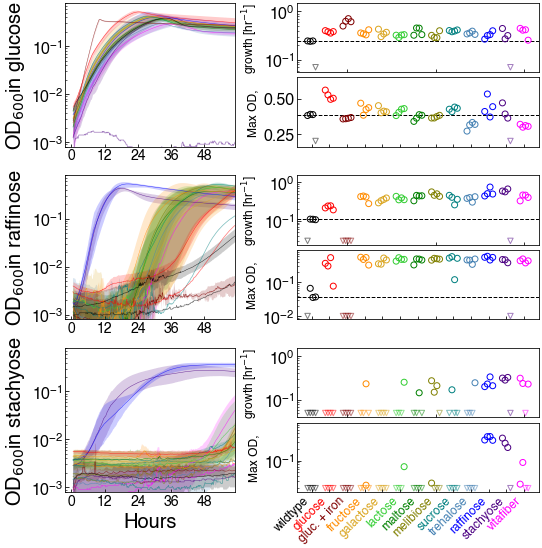

In [19]:
## load data
evolved_gc_data = pd.read_excel(f'{data_dir}/github_data/growth_curves.xlsx',
                        sheet_name = ['well_identities', 'plate1_evolved_gc_in_glucose', 'plate1_evolved_gc_in_raffinose', 'plate1_evolved_gc_in_stachyose'])

medium_to_well_map['unevolved'] = [('p1_A4', 'NA'), ('p1_B4', 'NA'), ('p1_C4', 'NA'),('p1_D4', 'NA'),]
shared.medium_labels['unevolved'] = 'wildtype'

## 
fig = plt.figure( figsize=(8.5, 9) )
gs = plt.GridSpec( nrows=3, ncols=2, wspace=0.3, width_ratios = [0.7, 1], figure=fig)

plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16

outer_ax = fig.add_subplot(gs[:, 0])
util.turn_off_ax(outer_ax)
outer_ax.set_xlabel('Hours', fontsize=20, labelpad=20)

OD_axs = []
summary_axs = []
for i, medium in enumerate(['glucose', 'raffinose', 'stachyose']):
    OD_ax = fig.add_subplot(gs[i, 0])
    OD_axs.append(OD_ax)
    OD_ax.set_ylabel(r'OD$_{600}$' + f'in {medium}', fontsize=20)
    inner_grid = gs[i, 1].subgridspec(2, 1, hspace=0.08)
    velocity_ax = fig.add_subplot(inner_grid[0])
    maxOD_ax = fig.add_subplot(inner_grid[1])
    summary_axs.append([velocity_ax, maxOD_ax])


medium_colors = {'glucose': 'red' ,'iron': 'maroon', 'fructose': 'darkorange', 'galactose': 'goldenrod', 
                 'lactose':'limegreen', 'maltose':'green', 'melibiose': 'olive', 'sucrose': 'teal', 'trehalose': 'steelblue',
                 'raffinose': 'blue', 'stachyose': 'indigo', 'vitafiber':'fuchsia',
                 'unevolved': 'black'}

ordered_media = [medium for medium in shared.ordered_media[::-1] if medium in medium_colors] + ['unevolved']


min_vals = {'glucose': (7e-2, 0.2), 'raffinose': (3e-2, 1e-2), 'stachyose': (5e-2, 2e-2)}
window = 10
for m, evol_medium in enumerate(ordered_media):
    wells = medium_to_well_map[evol_medium]
    plate = 1

    for row, growth_medium in enumerate(['glucose', 'raffinose', 'stachyose']):
        medium_growth_curves = evolved_gc_data[f'plate1_evolved_gc_in_{growth_medium}']
        times = medium_growth_curves.get('Time (hours)')
        times = (times.to_numpy()[:-window] + times.to_numpy()[window:])/2
        
        ax = OD_axs[row]
        velocity_ax, maxOD_ax = summary_axs[row]
        min_v, min_maxOD = min_vals[growth_medium]
    
        evo_replicates = []
        for r, (plate_well, bc_set) in enumerate(wells):
            well = plate_well.split('_')[1]
            gc = medium_growth_curves.get(well)

            sliding_median = [np.median(gc[i:i+window]) for i in range(len(gc)-window)] #average over noise
            evo_replicates.append(sliding_median)

        evo_replicates = np.array(evo_replicates)
        max_time_arg = np.where(np.array(times) <= 100)[0][-1] 
        evo_replicates = evo_replicates[:, :max_time_arg]
        times = times[:max_time_arg]

        blank_gcs = [np.median(medium_growth_curves.get(well)[i:i+window]) 
                     for well in ['A8', 'A12', 'B8', 'B12', 'C8', 'C12', 'D8', 'D12', 'E8', 'E12', 'F8', 'F12','G8', 'G12', 'H8', 'H12']
                     for i in range(len(medium_growth_curves.get(well))-window)]
        avg_blank = np.median(blank_gcs, axis=0)
        n_rep = len(evo_replicates)
        evo_replicates = np.array(evo_replicates) - np.tile(avg_blank, (n_rep, 1))

        growth_rates = []
        for evo_rep in evo_replicates:
            rep_growth_rates = []
            for idx0, OD0 in enumerate(evo_rep[:-1]):
                t0 = times[idx0]
                t1_indices = np.where(times > t0 + 6)[0]

                if not np.any(t1_indices):
                    break
                t1_idx = t1_indices[0]
                t1 = times[t1_idx]
                OD1 = evo_rep[t1_idx]

                with np.errstate(divide='ignore', invalid='ignore'): #ignore nans or zeros
                    growth_rate = np.log(OD1/OD0) / (t1 - t0)
                    if OD0 < 1e-3 or OD1 < 1e-2:
                        growth_rate = np.nan

                rep_growth_rates.append(growth_rate)
            growth_rates.append(rep_growth_rates)
        growth_rates = np.array(growth_rates)

        max_growth_rates = np.nanmax(growth_rates, axis=1)
        # print(f'Growth medium: {growth_medium}, Evolution medium: {evol_medium}, Max growth: {max_growth_rates}')
        # require at least ~ 2 divisions over timecourse
        detectable_growth_rate = (evo_replicates[:, -1] > 4 * evo_replicates[:, 0]) & (max_growth_rates > min_v) 

        for r, (max_growth, detect_bool) in enumerate( zip(max_growth_rates, detectable_growth_rate) ):
            if detect_bool:
                velocity_ax.scatter(-m + 0.15*r - 0.225, max_growth, color=medium_colors[evol_medium], marker='o', facecolors='none', alpha=1)
            else:
                velocity_ax.scatter(-m + 0.15*r - 0.225, min_v, color=medium_colors[evol_medium], marker='v', facecolors='none', alpha=0.5, s=30)
        
        max_ODs = np.max(evo_replicates, axis=1) #/ evo_replicates[:, 0]
        detectable_OD = (evo_replicates[:, -1] > 4 * evo_replicates[:, 0]) & (max_ODs > min_maxOD)

        for r, (max_OD, detect_bool) in enumerate( zip(max_ODs, detectable_OD) ):
            if detect_bool:
                maxOD_ax.scatter(-m + 0.15*r - 0.225, max_OD, color=medium_colors[evol_medium], marker='o', facecolors='none', alpha=1)
            else:
                maxOD_ax.scatter(-m + 0.15*r - 0.225, min_maxOD, color=medium_colors[evol_medium], marker='v', facecolors='none', alpha=0.5, s=30)

        if evol_medium == 'unevolved':
            velocity_ax.axhline(np.median(max_growth_rates[detectable_growth_rate]), color='black', lw=1, ls='--', zorder=0)
            maxOD_ax.axhline(np.median(max_ODs[detectable_OD]), color='black', lw=1, ls='--', zorder=0)


        final_OD = np.median(evo_replicates[:, -1])
        exclude = evo_replicates[:, -1] < final_OD/2
        for evo_gc in evo_replicates[exclude]:
            ax.plot(times[:max_time_arg], evo_gc[:max_time_arg], color=medium_colors[evol_medium], alpha=0.5)

        evo_replicates = evo_replicates[~exclude]
        ax.fill_between(times[:max_time_arg], y1=np.min(evo_replicates[:, :max_time_arg], axis=0), y2=np.max(evo_replicates[:, :max_time_arg], axis=0),
                        color=medium_colors[evol_medium], alpha=0.2, lw=0, zorder=0)
        ax.plot(times[:max_time_arg], np.mean(evo_replicates[:, :max_time_arg], axis=0), color=medium_colors[evol_medium], lw=0.5, alpha=0.75)


for row, (growth_medium, ax, [vel_ax, OD_ax]) in enumerate(zip(['glucose', 'raffinose', 'stachyose'], OD_axs, summary_axs)):
    ax.set_xlim(ax.get_xlim()[0], 59)
    ax.set_yscale('log')
    ax.set_ylim(8*10**-4, 0.8)
    ax.set_xticks([0, 12, 24, 36, 48])
    ax.set_xticklabels([0, 12, 24, 36, 48], fontsize=14)

    vel_ax.set_ylabel('growth [hr$^{-1}$]', fontsize=12)
    vel_ax.set_yscale('log')
    vel_ax.set_xticklabels([])

    OD_ax.set_ylabel('Max OD,', fontsize=12)
    OD_ax.set_yscale('log')
    OD_ax.set_xticks(-np.arange(len(ordered_media)))
    if row == 2:
        OD_ax.set_xticklabels([shared.medium_labels[medium] for medium in ordered_media], rotation=45, fontsize=12, ha='right')
        for xtick, medium in zip(maxOD_ax.get_xticklabels(), ordered_media):
            xtick.set_color(medium_colors[medium])

    else:
        OD_ax.set_xticklabels([])
    
    if growth_medium == 'glucose':
        min_v, min_maxOD = min_vals[growth_medium]
        vel_ax.set_ylim(0.8*min_v, 1.5)
        OD_ax.set_ylim(0.8*min_maxOD, 0.65)
        OD_ax.set_yscale('linear')

    if growth_medium == 'raffinose':
        min_v, min_maxOD = min_vals[growth_medium]
        vel_ax.set_ylim(0.8*min_v, 1.5)
        OD_ax.set_ylim(0.8*min_maxOD, 0.9)

    if growth_medium == 'stachyose':
        min_v, min_maxOD = min_vals[growth_medium]
        vel_ax.set_ylim(0.8*min_v, 1.5)
        OD_ax.set_ylim(0.8*min_maxOD, 0.9)

fig.savefig(f'../figures/evolved_pleiotropy_gcs.pdf')

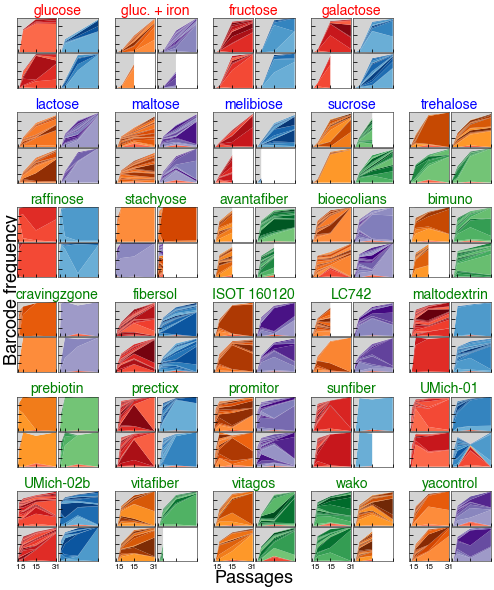

In [21]:
fig = plt.figure( figsize=(8.5, 10) )
gs = plt.GridSpec( nrows=6, ncols=5, wspace=0.2, hspace=0.35, figure=fig)
outer_ax = fig.add_subplot(gs[:])
util.turn_off_ax(outer_ax)
outer_ax.set_xlabel('Passages', fontsize=18, labelpad=8)
outer_ax.set_ylabel('Barcode frequency', fontsize=18, labelpad=-4)


bc_set_colors = {'V1': 'Reds', 'V2':'Oranges', 'V3': 'YlOrBr', 'V4':'Blues', 'V5':'Purples', 'V6':'Greens'}
# bc_set_colors = {'V1': 'hsv', 'V2':'hsv', 'V3': 'hsv', 'V4':'hsv', 'V5':'hsv', 'V6':'hsv'}

spine_colors = {medium: 'red' for medium in shared.MONOSACCHARIDES} \
    | {medium: 'blue' for medium in shared.DISACCHARIDES} \
    | {medium: 'green' for medium in shared.OLIGOSACCHARIDES + shared.POLYSACCHARIDES}  

medium_color='blue'
window = 10
for m, medium in enumerate(shared.ordered_media[:]):
    if m >= 4: m += 1
    outer_ax = fig.add_subplot(gs[m//5, m%5])
    util.turn_off_ax(outer_ax)
    # for spine in outer_ax.spines.values():
        # spine.set_edgecolor(spine_colors[medium])
        # spine.set_linewidth(5)
    outer_ax.text(0.5, 1.05, shared.medium_labels[medium], fontsize=14, transform=outer_ax.transAxes, ha='center', color=spine_colors[medium])
    

for m, medium in enumerate(shared.ordered_media[:]):
    if m >= 4: m += 1
    wells = medium_to_well_map[medium]
    inner_grid = gs[m//5, m%5].subgridspec(2, 2, hspace=0.03, wspace=0.05)

    for r, (plate_well, bc_set) in enumerate(wells):
        plate = int(plate_well.split('_')[0].strip('p'))
        well = plate_well.split('_')[1]

        well_passages, well_rows = vitro_meta[plate_well]
        well_freqs = vitro_freqs[well_rows]

        large_indices = np.where(np.max(well_freqs, axis=0) > 0.01)[0]

        ordered_indices, ordered_colors = shared.order_barcodes_by_pool(large_indices, shared.barcode_pool_assignments,
                                                                        [(bc_set, bc_set_colors[bc_set]) for bc_set in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']], 
                                                                        cg_at_end=True, cg_all_low_freqs=True)
        

        days, freqs = shared.make_vitro_muller_freqs(well_passages, well_freqs, ordered_indices, 18)

        ax = fig.add_subplot(inner_grid[r//2, r%2])
        
        shared.muller_plot(ax, days, ordered_indices, freqs, ordered_colors)

        ax.set_xticks([1, 5, 15, 31])
        ax.set_xticklabels([])
        ax.set_yticks([0.25, 0.5, 0.75])
        ax.set_yticklabels([])
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 31)

        for spine in ax.spines.values():
            spine.set_linewidth(0.5)

        if m//5 == 5 and r == 2:
            ax.set_xticklabels([1, 5, 15, 31], fontsize=8)
  
fig.savefig(f'../figures/sfig_all_vitro_barcode_dynamics.pdf', transparent=True, bbox_inches='tight')


AttributeError: module 'scipy' has no attribute 'stats'

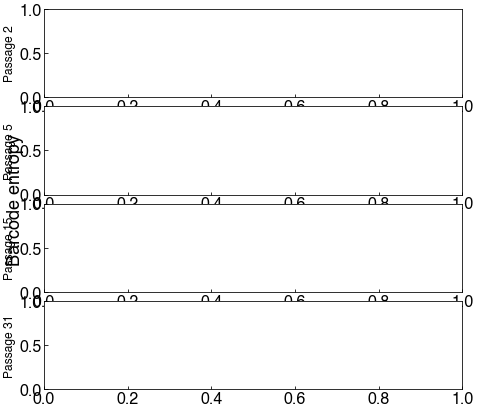

In [23]:
MIN_FREQ = 0

focal_passage_times = np.array([2, 5, 15, 31])

fig = plt.figure(figsize = (7.5, 7))
gs = plt.GridSpec( nrows=4, ncols=1, hspace=0.1, figure=fig)
outer_ax = fig.add_subplot(gs[:])
util.turn_off_ax(outer_ax)
outer_ax.set_ylabel('Barcode entropy', fontsize=18, labelpad=20)

axs = [fig.add_subplot(gs[i]) for i in range(4)]
for ax, passage in zip(axs, focal_passage_times):
    # ax.set_ylim(-0.3, 8.75)
    ax.set_ylabel(f'Passage {passage}', fontsize=12)

inoc_marker_map = {'V1':'o', 'V2':'v', 'V3': 'D', 'V4': 's', 'V5': '^', 'V6': 'h'}

for m, medium in enumerate(shared.ordered_media[:]):

    wells = medium_to_well_map[medium]

    for r, (plate_well, bc_set)in enumerate(wells):
        marker = inoc_marker_map[bc_set]

        plate = int(plate_well.split('_')[0].strip('p'))
        well = plate_well.split('_')[1]

        well_passages, well_rows = vitro_meta[plate_well]
        well_freqs = vitro_freqs[well_rows]

        entropies = []
        for row, passage in enumerate(focal_passage_times):
            ax = axs[row]

            if passage in well_passages:
                idx = np.where(well_passages == passage)[0][0]
                entropy = shared.calc_entropy([well_freqs[idx]], min_freq=MIN_FREQ)
                ax.scatter(m + 0.1*r - 0.15, entropy,  marker=marker, facecolors='none', color=shared.VITRO_MEDIA_COLORS[medium])

            else:
                entropies.append(np.nan)


for row, ax in enumerate(axs):

    ax.set_xticks(np.arange(len(shared.ordered_media)))
    ax.set_xticklabels([])
    ax.set_xlim(-1, 29)
    ax.axvspan(3.5, 8.5, color='grey', alpha=0.2, lw=0)

    yticks = np.arange(0, int(ax.get_ylim()[1])+1)
    if len(yticks) > 8:
        yticks = yticks[::2]
    ax.set_yticks(yticks)

    ax.set_ylim(-0.5, ax.get_ylim()[1]+0.5)
    if ax.get_ylim()[1] > 8:
        day0_freqs = vitro_freqs[ [vitro_row_ids[('vitro', inoc, 0)] for inoc in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']] ]
        day0_entropies = shared.calc_entropy(day0_freqs, min_freq=MIN_FREQ)
        ax.axhspan(np.min(day0_entropies), np.max(day0_entropies), color='tomato', alpha=0.7, lw=0, zorder=0)
        ax.set_ylim(-0.5, 10)
        ax.text(0.99, 0.975, 'Inoculum entropy', transform=ax.transAxes, color='red', ha='right', va='top')
    


    if row == 0:
        ax.text(0.075, 1.05, 'Mono-', transform=ax.transAxes, fontsize=18, va='bottom', ha='center')
        ax.text(0.24, 1.05, 'Di-', transform=ax.transAxes, fontsize=18, va='bottom', ha='center')
        ax.text(0.65, 1.05, 'Oligo/poly-saccharides', transform=ax.transAxes, fontsize=18, va='bottom', ha='center')
    if row == 3:

        ax.set_xticklabels(shared.ordered_media, rotation=45, ha='right', fontsize=10)
        for xtick, medium in zip(ax.get_xticklabels(), shared.ordered_media):
            xtick.set_color(shared.VITRO_MEDIA_COLORS[medium])

fig.savefig(f'../figures/sfig_all_entropies.pdf', transparent=True, bbox_inches='tight')